In [1]:
import os
import zipfile

In [2]:
os.listdir('../input/dogs-vs-cats-redux-kernels-edition')
os.makedirs('../data', exist_ok=True)

base_dir = '../input/dogs-vs-cats-redux-kernels-edition'
train_dir = '../data/train'
test_dir = '../data/test'

In [3]:
with zipfile.ZipFile(os.path.join(base_dir, 'train.zip')) as train_zip:
    train_zip.extractall('../data')
    
with zipfile.ZipFile(os.path.join(base_dir, 'test.zip')) as test_zip:
    test_zip.extractall('../data')

In [4]:
import glob
os.listdir(train_dir)[:5]
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [8]:
import matplotlib.pyplot as plt
import numpy as np

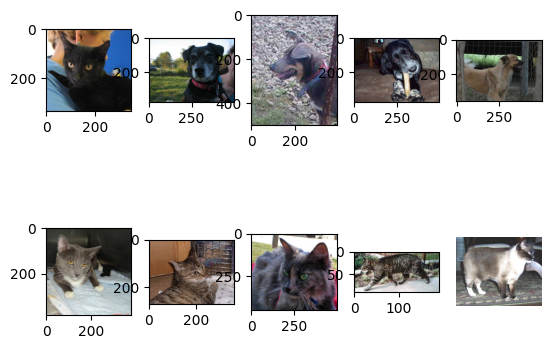

In [9]:
from PIL import Image
random_idx = np.random.randint(1,25000,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = Image.open(train_list[idx])
    plt.imshow(img)
    i+=1

plt.axis('off')
plt.show()

In [10]:
print(len(train_list), len(test_list))

25000 12500


In [11]:
from sklearn.model_selection import train_test_split
train_list, val_list = train_test_split(train_list, test_size=0.05)

In [12]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

In [15]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

In [16]:
class dataset(torch.utils.data.Dataset):
   
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    

    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [17]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)

In [29]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [30]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))

23750 238
1250 13


In [53]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.Softplus(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.Softplus(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.Softplus(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.selu = nn.Softplus()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.selu(self.fc1(out))
        out = self.fc2(out)
        return out

In [54]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=1, threshold=20)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=1, threshold=20)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Softplus(beta=1, threshold=20)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace

In [55]:
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

In [57]:
import time

# Define the file name to save the results
file_name = "training_results_with_softplus.txt"

# Open the file in write mode
with open(file_name, "a") as file:
    for epoch in range(epochs):
        start_time = time.time()  # Record start time for epoch
        
        epoch_loss = 0
        epoch_accuracy = 0
        steps = 0  # Counter to keep track of steps

        for data, label in train_loader:
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = ((output.argmax(dim=1) == label).float().mean())
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)
            steps += 1

            if steps % 50 == 0:  # Print loss after every 50 steps
                print('Epoch : {}, Step : {}, train loss : {:.4f}'.format(epoch + 1, steps, loss))

        epoch_time = time.time() - start_time  # Calculate time taken for epoch
        
        file.write('{},{:.4f},{:.4f},{:,.4f}\n'.format(epoch + 1, epoch_accuracy, epoch_loss,epoch_time))
        print('Epoch : {}, train accuracy : {:.4f}, train loss : {:.4f}\n'.format(epoch + 1, epoch_accuracy, epoch_loss))
        
        with torch.no_grad():
            start_time = time.time()
            epoch_val_accuracy = 0
            epoch_val_loss = 0
            for data, label in val_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                val_loss = criterion(val_output, label)

                acc = ((val_output.argmax(dim=1) == label).float().mean())
                epoch_val_accuracy += acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)
            val_epoch_time = time.time() - start_time
            file.write('{},{:.4f},{:.4f},{:.4f}\n'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss,val_epoch_time))
            print('Epoch : {}, val_accuracy : {:.4f}, val_loss : {:.4f}\n'.format(epoch + 1, epoch_val_accuracy, epoch_val_loss))


Epoch : 1, Step : 50, train loss : 0.7088
Epoch : 1, Step : 100, train loss : 0.6071
Epoch : 1, Step : 150, train loss : 0.5980
Epoch : 1, Step : 200, train loss : 0.6255
Epoch : 1, train accuracy : 0.6282, train loss : 0.6397

Epoch : 1, val_accuracy : 0.6754, val_loss : 0.5907

Epoch : 2, Step : 50, train loss : 0.5842
Epoch : 2, Step : 100, train loss : 0.5555
Epoch : 2, Step : 150, train loss : 0.5628
Epoch : 2, Step : 200, train loss : 0.5572
Epoch : 2, train accuracy : 0.6976, train loss : 0.5765

Epoch : 2, val_accuracy : 0.7100, val_loss : 0.5603

Epoch : 3, Step : 50, train loss : 0.5060
Epoch : 3, Step : 100, train loss : 0.5415
Epoch : 3, Step : 150, train loss : 0.4759
Epoch : 3, Step : 200, train loss : 0.5407
Epoch : 3, train accuracy : 0.7266, train loss : 0.5415

Epoch : 3, val_accuracy : 0.7208, val_loss : 0.5339

Epoch : 4, Step : 50, train loss : 0.4535
Epoch : 4, Step : 100, train loss : 0.5592
Epoch : 4, Step : 150, train loss : 0.5103
Epoch : 4, Step : 200, train 